In [2]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# our functions
import setup
import data
import visualizations
import basis_functions
import kernels
pd.set_option('float_format', '{:f}'.format)
setup.set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

In [3]:
manhattan = data.get_borough_data("data/preprocessed.csv", "Manhattan")
ues_to_msh = data.get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)

In [4]:
indicator_cols = ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "manhattan_distance", "pickup_hour", "pickup_timestamp"]
y_cols = ["trip_duration"]

x_train_raw, y_train_raw, x_test_raw, y_test_raw = data.train_test_split(ues_to_msh, 0.1, indicator_cols, y_cols)
x_train = data.standardize_cols(x_train_raw)
x_test = data.standardize_cols(x_test_raw)


# Box's Loop - Iteration 3

## Model: Gaussian Process

Gaussian processes (GPs) are a supervised machine learning algorithm that measures the similarity between input data points, using a predefined kernel function, to predict the value of an unseen data point. We like to think about GPs as: defining an infinite distribution on functions over a continuous sapce where we observe some data points and want to assign probabilities to all the ways a line could be drawn through those points. The idea is that we hope these lines (or functions) we draw are similar with high probability to that true function which we will never know. 

Drawing a parallel to our polynomial basis GLM example: instead of choosing a polynomial basis function of degree four, with GPs using a kernel function we'd like to infer the true function from our data. Hence, GPs allow us retain the flexibility of capturing non-linearities in our data but accounting for "infinite" numbers of basis functions. 

### Interpretation of Kernel Function

GPs are parameterized by a pre-determined *kernel function* which is positive-semidefinite covariance matrix that calculated distanced between every pair of $N$ observed points. The Kernel function must be a square matrix and allows use to explore *smoothness* and *periodicity* in our observed data. 

In our analysis we will explore a few kernel functions but note there are many popular kernel functions, some more applicable than others and exploring them all was impossible. 

### Model Overview

A GP can be specified entirely by it's Kernel Function and mean (often assumed to 0): 

Where,

**Prior:** $p(f) = GP(\ 0,\ K(x,x',\theta)\ )$ where $\theta$ = *length_scale* $l_f$, sigma $\sigma_f$

**Likelihood:**  $p(y\ |\ f,\ X,\ \theta) = GP(\ f,\ K(x,x', \theta)\ )$

In [14]:
def gp_reg_invert_K(x, y, x_star, kernel):
    K = kernel(x)
    k_star = kernel(x_star, x)
    k_star_star = kernel(x_star, x_star)
    mu_n, sigma_n_sqr = tf.nn.moments(y, 1)
    K_noisy = K + sigma_n_sqr * tf.eye(tf.cast(x.get_shape()[0], tf.int32), dtype=tf.float64)
    K_noisy_inv = tf.matrix_inverse(K_noisy)
    f_bar = tf.matmul(tf.matmul(k_star, K_noisy_inv), y)
    tmp = tf.matmul(tf.matmul(k_star, K_noisy_inv), k_star, transpose_b=True)
    v = k_star_star - tmp
    return f_bar, v

y = tf.constant(y_train_raw.as_matrix())
x = tf.constant(x_train)
x_star = tf.constant(x_test)

f, v = gp_reg_invert_K(x, y, x_star, kernels.rbf)
mean = np.reshape(f.eval(session=tf.Session()), -1)
covariance = v.eval(session=tf.Session())
sample = np.random.multivariate_normal(mean, covariance)

err = np.abs(sample - y_test_raw.as_matrix())
err.mean()

7.0440970371166713

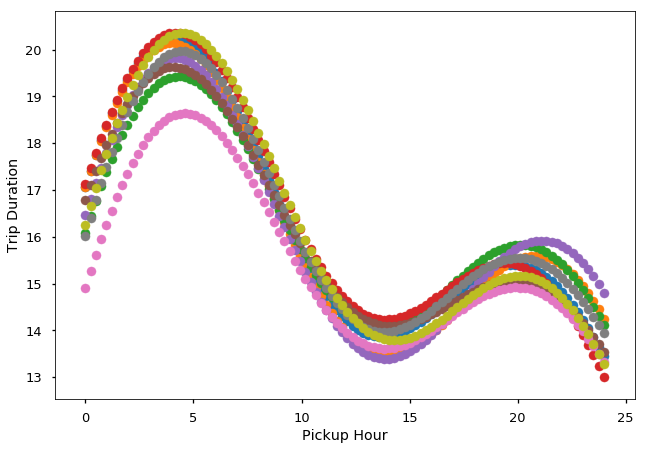

In [25]:
def vis_gp(x, y, kernel, indicator_cols, num_samples, interp_pnts=100):
    times = np.linspace(0, 24, interp_pnts)
    x_vis = pd.DataFrame({i: [0.0] * interp_pnts for i in indicator_cols})
    x_vis["pickup_hour"] = times
    x_vis["pickup_timestamp"] = x_vis["pickup_hour"].apply(lambda x: pd.to_datetime(x, unit="s").hour)
    x_vis_stdzd = data.standardize_cols(x_vis).fillna(0.0)
    for i in range(num_samples - 1):
        f, v = gp_reg_invert_K(x, y, x_vis_stdzd, kernel)
        mean = np.reshape(f.eval(session=tf.Session()), -1)
        covariance = v.eval(session=tf.Session())
        samples = np.random.multivariate_normal(mean, covariance)
        plt.scatter(x=times, y=samples)
    plt.xlabel("Pickup Hour")
    plt.ylabel("Trip Duration")
    plt.show()
    
vis_gp(x, y, kernels.rbf, indicator_cols, 10)